# Codelabs1: Text detection using Google Cloud Vision API

The Vision API runs OCR, similar to the model used in Google Translate, to extract the following text from the image and identify that the text is in English

The Vision API can detect and extract text from images. There are two annotation features that support optical character recognition:

* **TEXT_DETECTION:** detects and extracts text from any image. For example, a photograph might contain a street sign or traffic sign. The JSON includes the entire extracted string, as well as individual words, and their bounding boxes. <div>



* **DOCUMENT_TEXT_DETECTION:** also extracts text from an image, but the response is optimized for dense text and documents. The JSON includes page, block, paragraph, word, and break information. <div>






<img src = "./img/cloud_ml_ocr.png" width=720>

In [1]:
from google.cloud import vision
from google.cloud.vision import types
import io
from PIL import Image, ImageDraw
from enum import Enum
import pandas as pd

## Input  

### Converting PDF to JPG format

Input file is in pdf format. We will convert the pdf file into image (jpg) format using [pdf2image](https://pypi.org/project/pdf2image/) library.

In [2]:
pdf_file_path = "./img/form.pdf"

from pdf2image import convert_from_path
pages = convert_from_path(pdf_file_path)
pages[0].save("./img/converted_form.jpg")

Let's check how does the converted form look. 

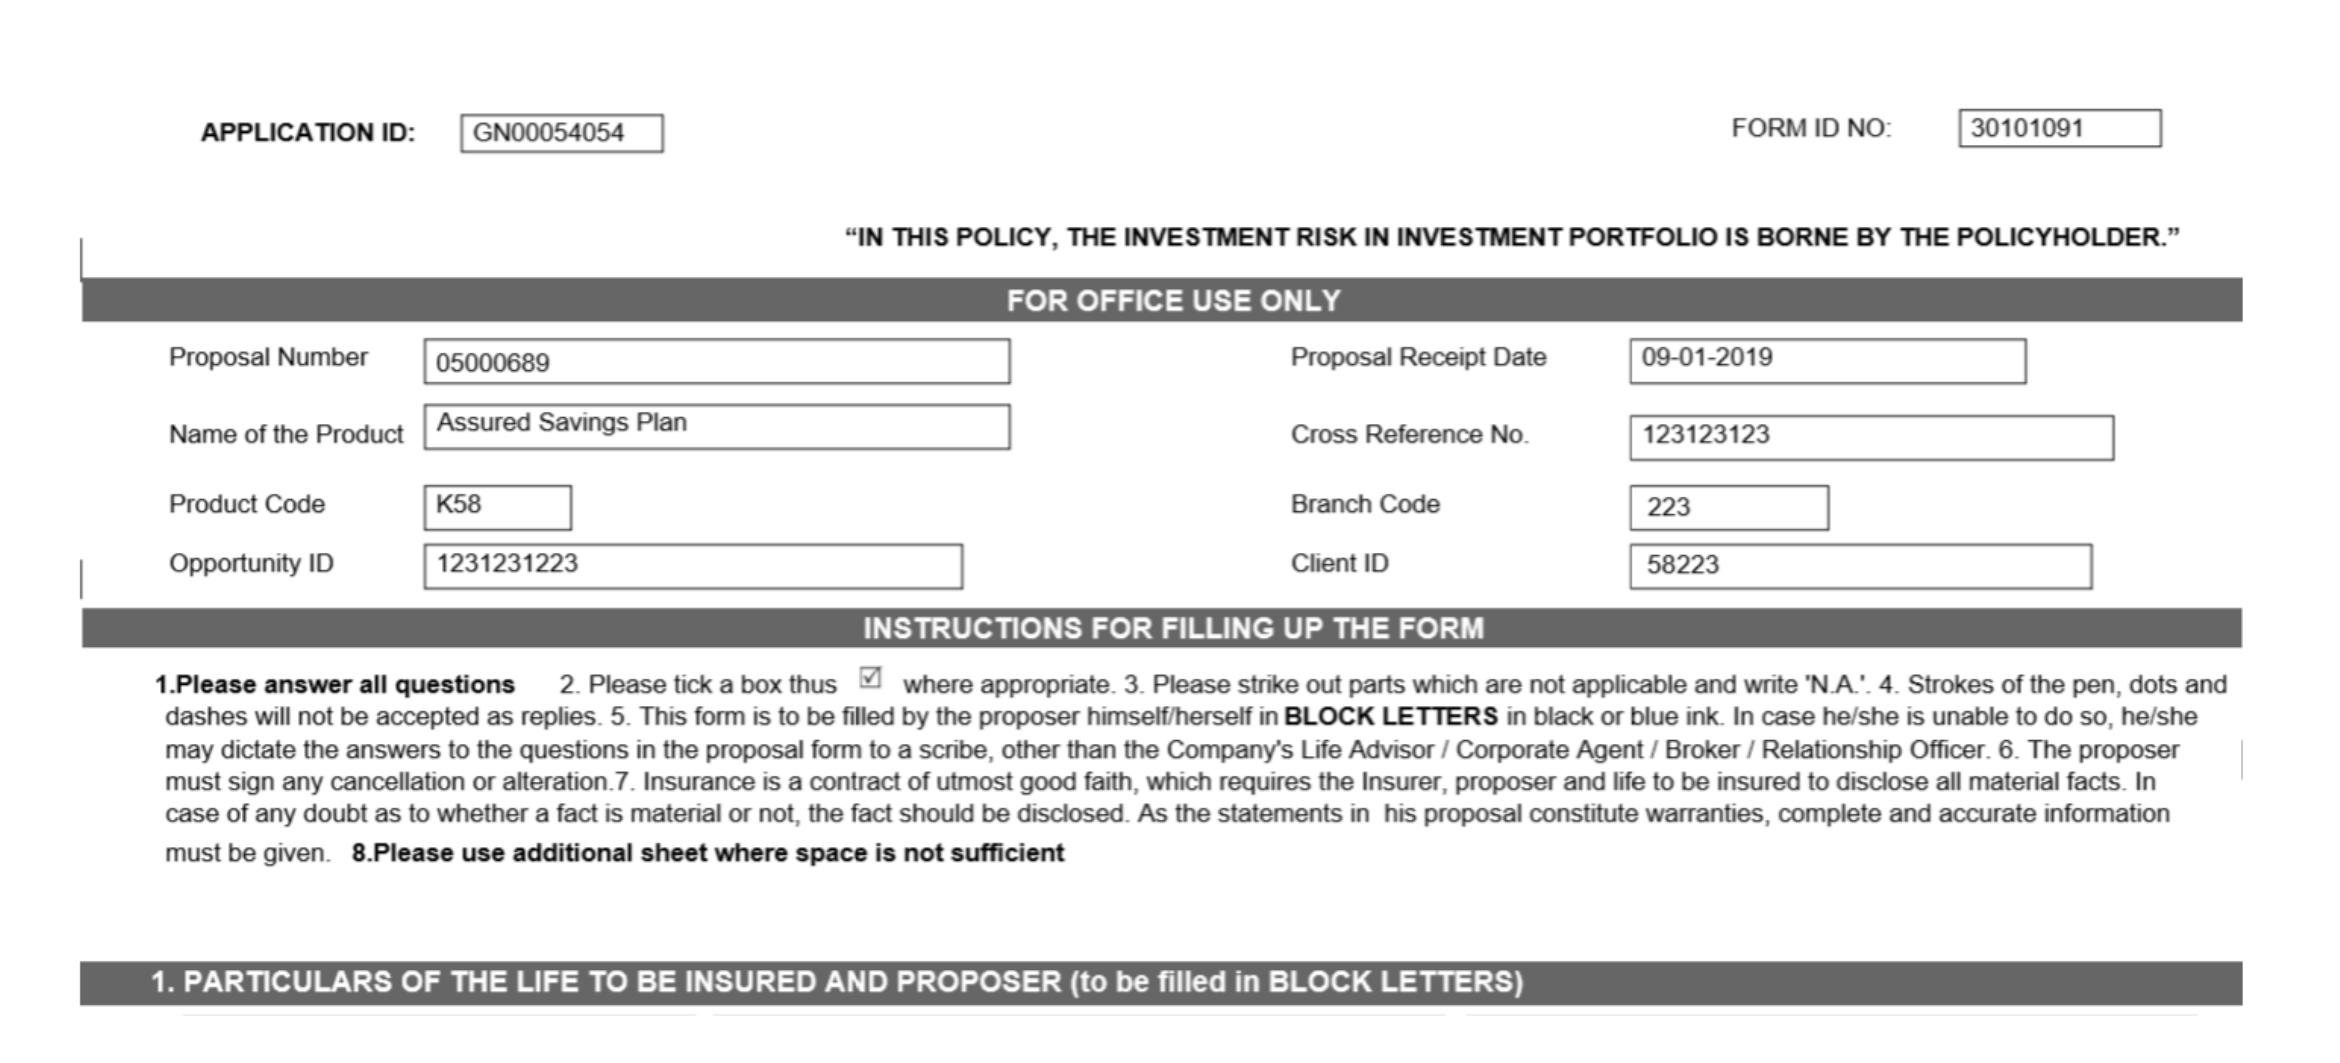

In [3]:
image_file='./img/converted_form.jpg'  ## printed data
# image_file='images/sample.png'    ## error data
# image_file='images/cloudML.png'    ## handwritten data


image  = Image.open(image_file)
image

# Calling the API


Using Google cloud vision API for document_text_detection. Its response includes page, block, paragraph, word, and break information.



In [4]:
''' 
Calling google cloud vision API (text detection) 
   
'''

client = vision.ImageAnnotatorClient()
with io.open(image_file, 'rb') as image_file1:
        content = image_file1.read()
content_image = types.Image(content=content)
response = client.document_text_detection(image=content_image)
document = response.full_text_annotation

## Response of API

In [ ]:
document

# Plotting bounding boxes from the response.

As we know that after calling the API, we get page, block, paragraph, word, and break information in response. Lets see how we can plot bounding boxes around words, paragraphs, etc. <div>
There are five level of document text detection:
* PAGE <div>
* BLOCK<div>
* PARA<div>
* WORD<div>
* SYMBOL

In [5]:
class FeatureType(Enum):
    PAGE = 1
    BLOCK = 2
    PARA = 3
    WORD = 4
    SYMBOL = 5
    
def draw_boxes(image, bounds, color,width=5):
    draw = ImageDraw.Draw(image)
    for bound in bounds:
        draw.line([
            bound.vertices[0].x, bound.vertices[0].y,
            bound.vertices[1].x, bound.vertices[1].y,
            bound.vertices[2].x, bound.vertices[2].y,
            bound.vertices[3].x, bound.vertices[3].y,
            bound.vertices[0].x, bound.vertices[0].y],fill=color, width=width)
    return image

def get_document_bounds(response, feature):
    bounds=[]
    for i,page in enumerate(document.pages):
        for block in page.blocks:
            if feature==FeatureType.BLOCK:
                bounds.append(block.bounding_box)
            for paragraph in block.paragraphs:
                if feature==FeatureType.PARA:
                    bounds.append(paragraph.bounding_box)
                for word in paragraph.words:
                    for symbol in word.symbols:
                        if (feature == FeatureType.SYMBOL):
                            bounds.append(symbol.bounding_box)
                    if (feature == FeatureType.WORD):
                        bounds.append(word.bounding_box)
    return bounds

### Plotting bounding box on all words in image.

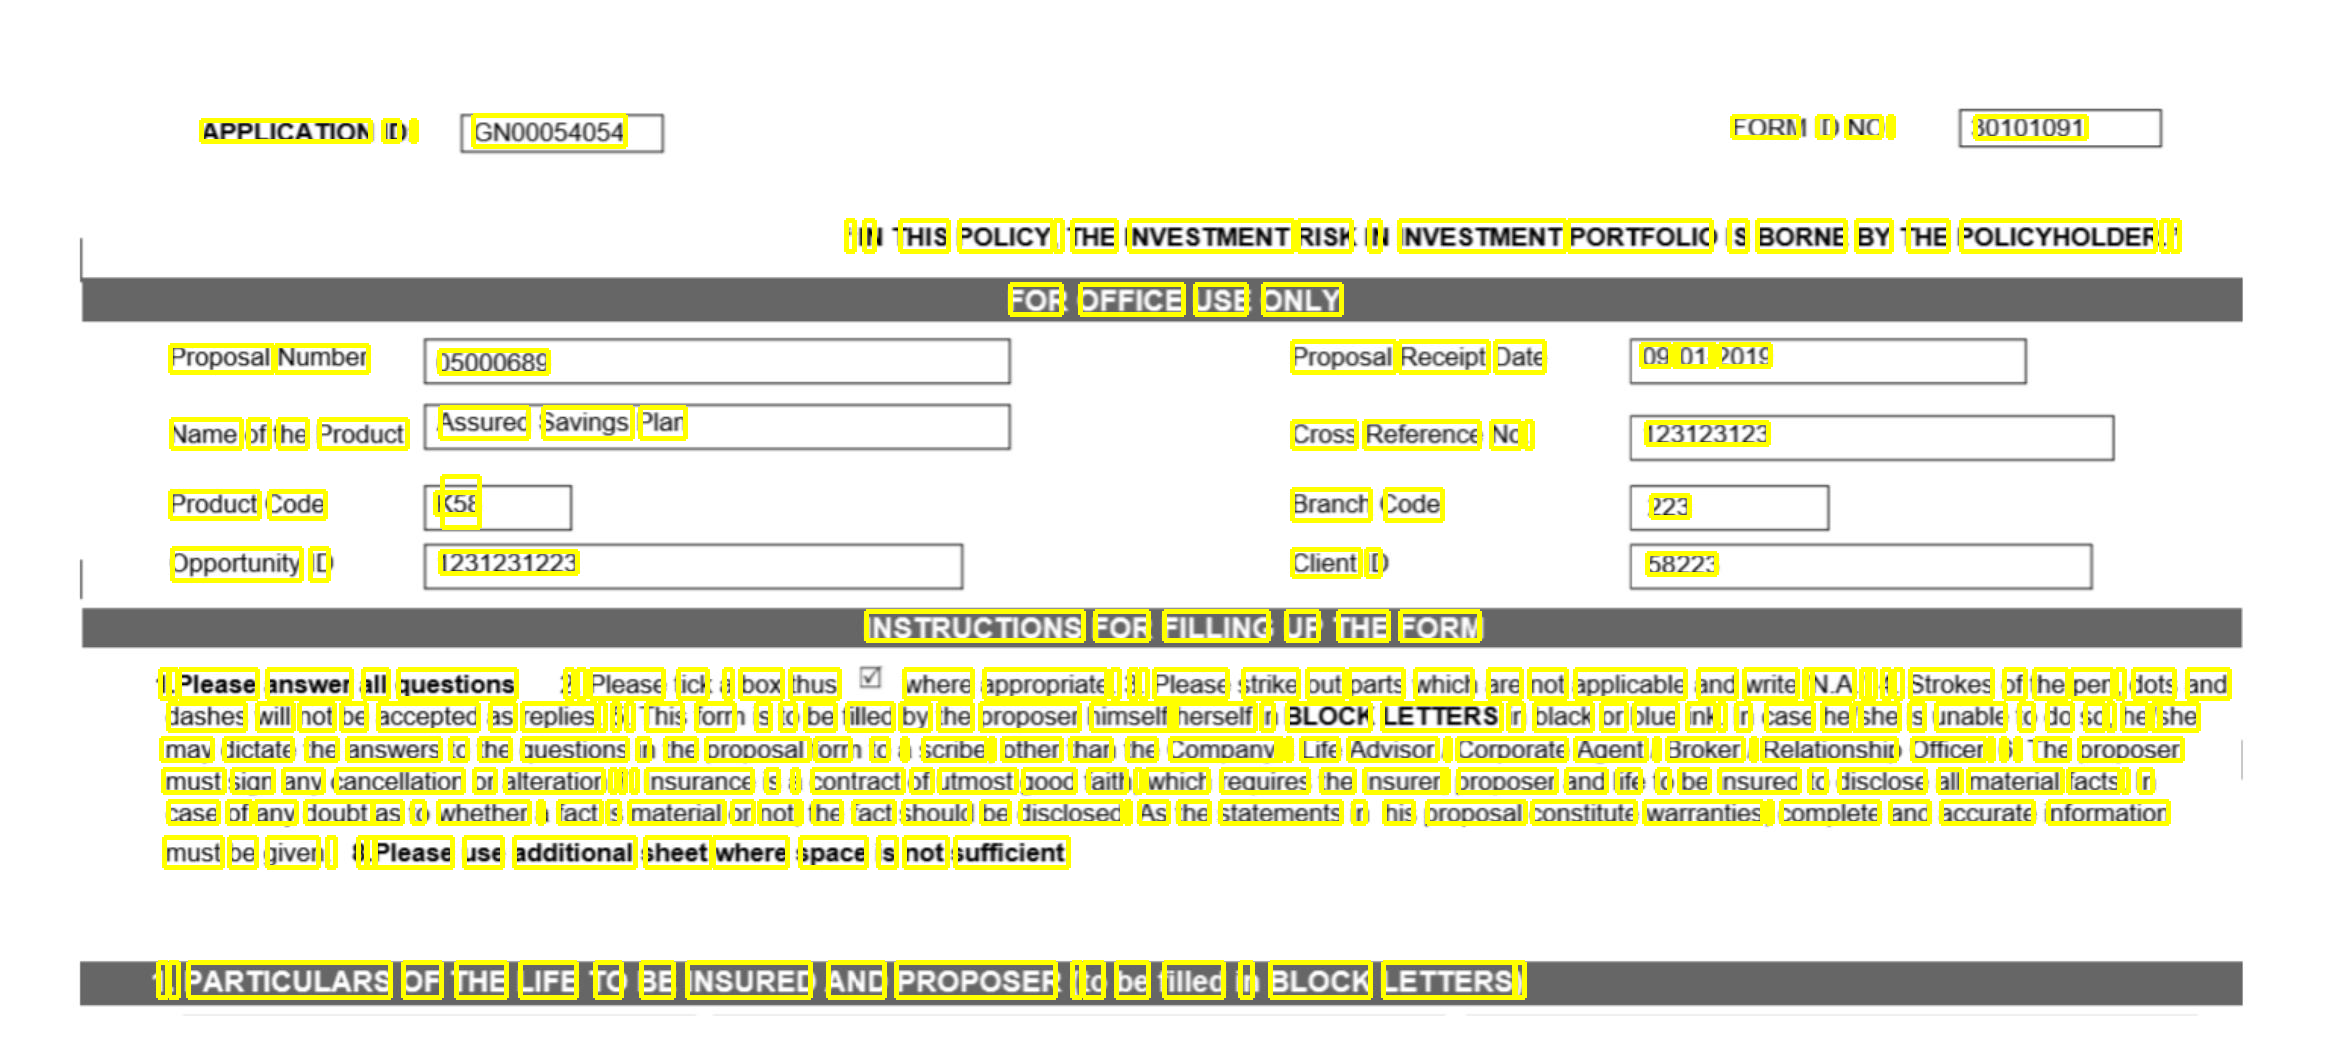

In [6]:

bounds = get_document_bounds(response, FeatureType.WORD)
draw_boxes(image, bounds, 'yellow')

### Plotting bounding box on all BLOCKS in image.

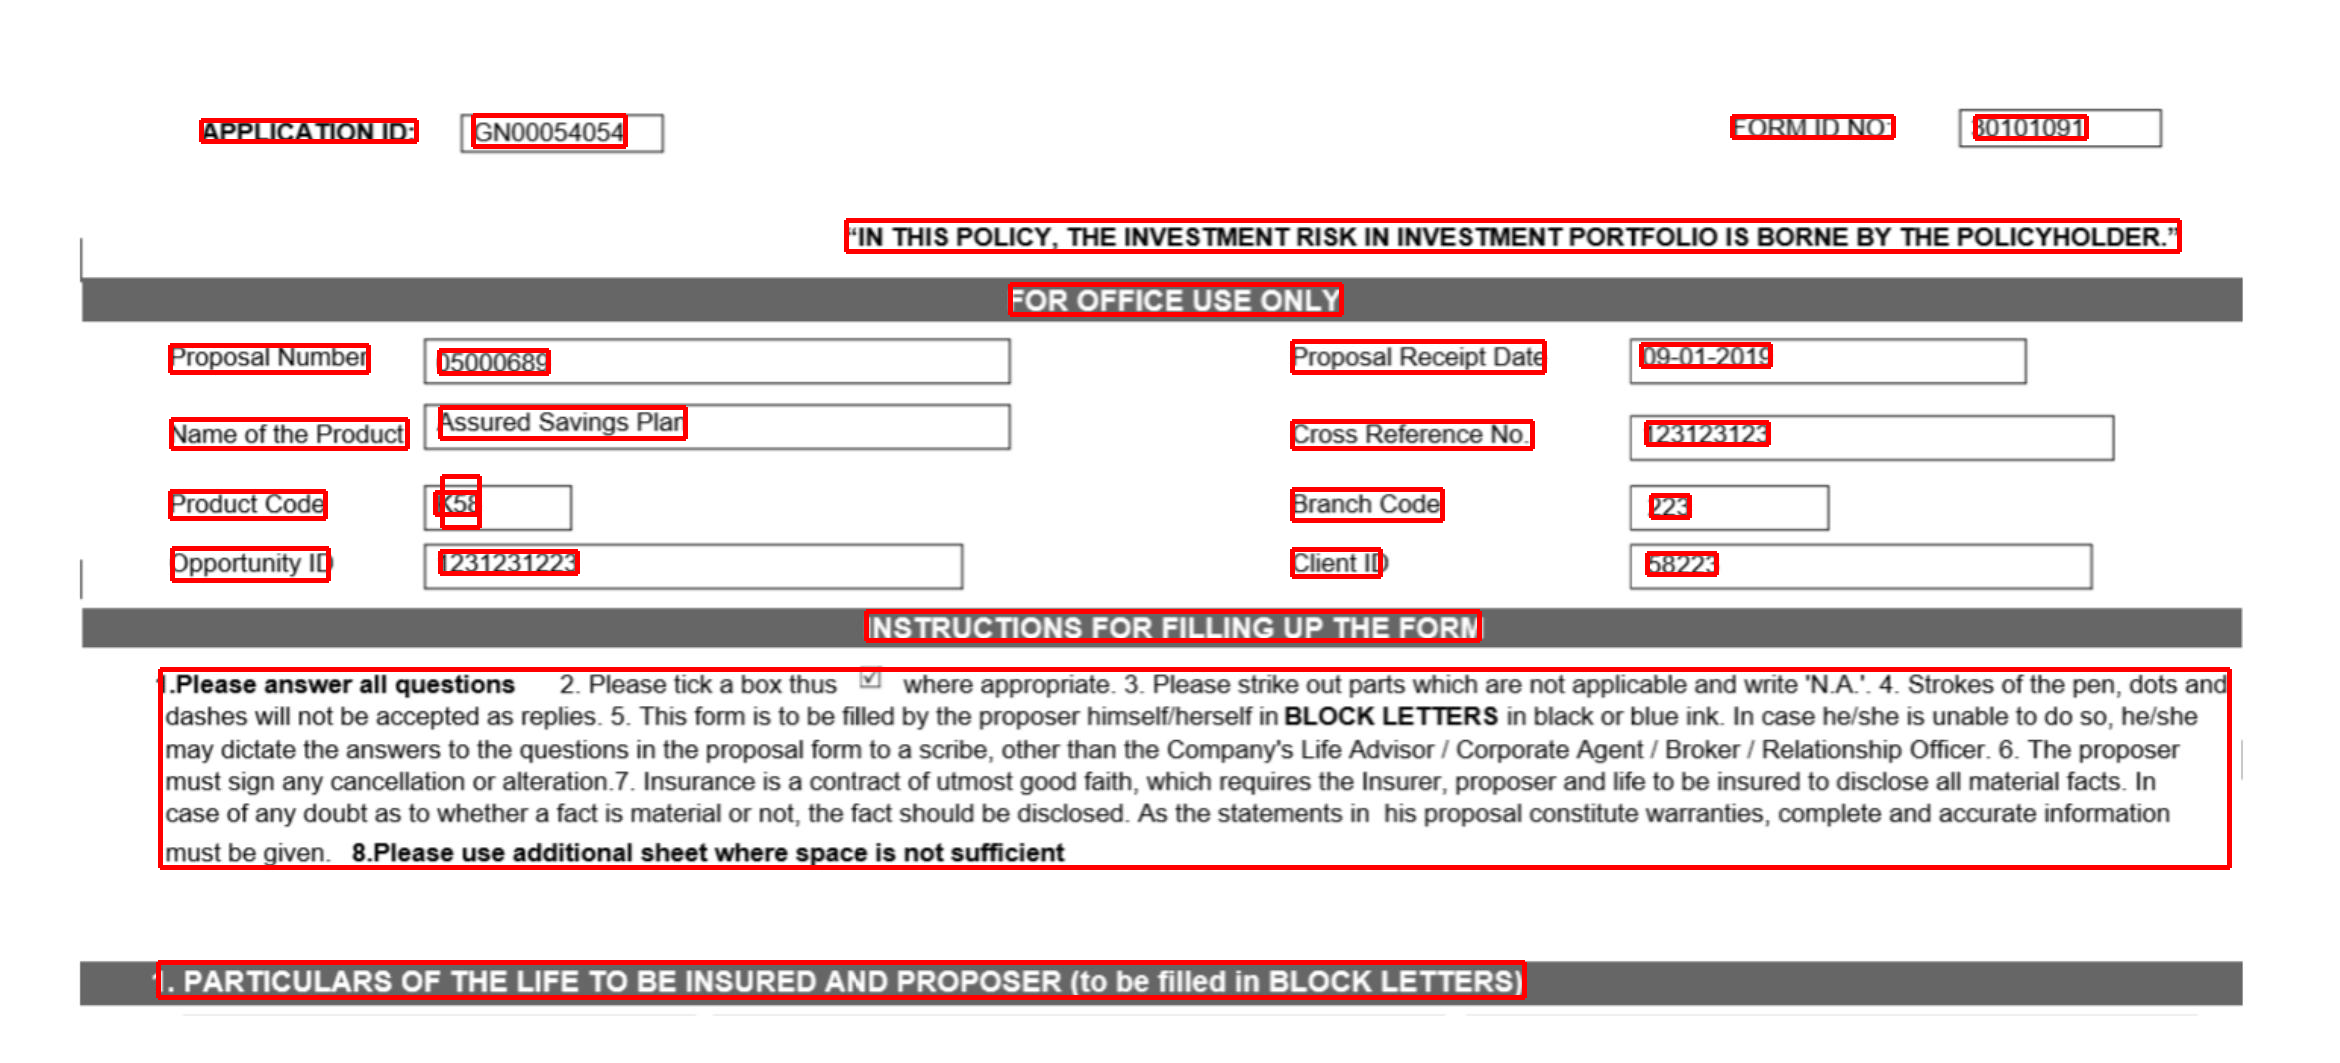

In [7]:
#Plotting bounding box on BLOCKS.
bounds = get_document_bounds(response, FeatureType.BLOCK)
draw_boxes(Image.open(image_file), bounds, 'red')

# Finding location of a single word

From the response of Cloud Vision API for document_text_detection, we can find location of single word. The code below gives the vertices of bounding box of the word in response.

In [8]:
def assemble_word(word):
    assembled_word=""
    for symbol in word.symbols:
        assembled_word+=symbol.text
    return assembled_word

def find_word_location(document,word_to_find):
    bounds=[]
    for page in document.pages:
        for block in page.blocks:
            for paragraph in block.paragraphs:
                for word in paragraph.words:
                    assembled_word=assemble_word(word)
                    if(assembled_word==word_to_find):
                        bounds.append(word.bounding_box)
    return bounds
find_word_location(document,"APPLICATION")

[vertices {
   x: 201
   y: 120
 }
 vertices {
   x: 370
   y: 120
 }
 vertices {
   x: 370
   y: 141
 }
 vertices {
   x: 201
   y: 141
 }]

# Finding location of multiple words

We can also find location of multiple words OR sentence. The code below gives the vertices of boundong box of the all words in response.

In [9]:
def assemble_word(word):
    assembled_word=""
    for symbol in word.symbols:
        assembled_word+=symbol.text
    return assembled_word

def find_word_location(document,word_to_find):
    count = len(word_to_find.split(" "))
    word_to_find = word_to_find.replace(" ", "")
    bounds=[]
    for page in document.pages:
        for block in page.blocks:
            for paragraph in block.paragraphs:
                all_words = paragraph.words
                for i in range(len(all_words)):
                    assembled_word = ""
                    for j in range(count):
                        if(i+j) < len(all_words):
                            assembled_word = assembled_word + assemble_word(all_words[i+j])
                            c=i
#                             print(assembled_word)
                    if(assembled_word==word_to_find):
                        for z in range(count):
                            bounds.append(all_words[c+z].bounding_box)
    return bounds

### Plotting bounding box on searched words

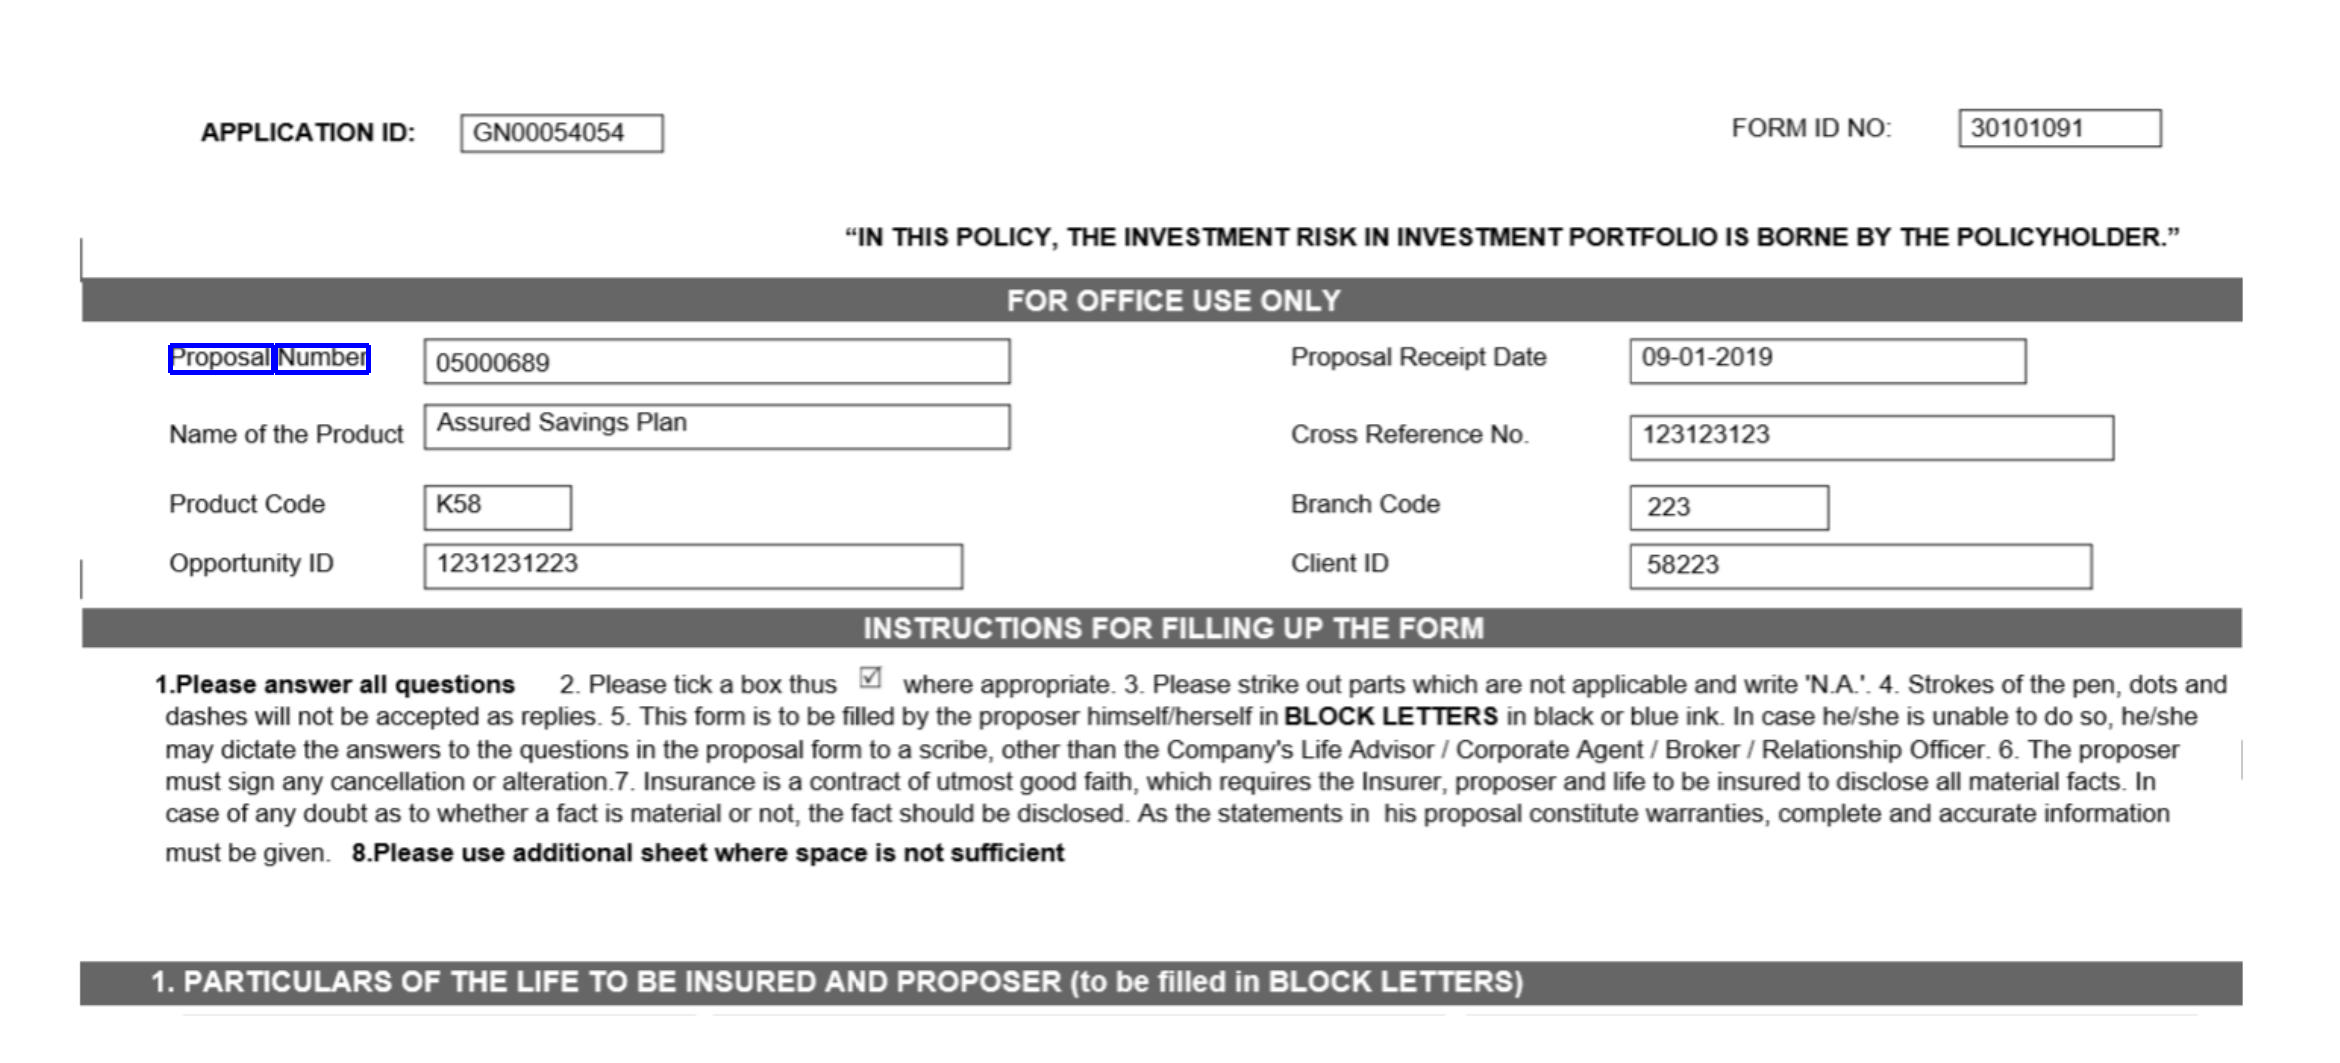

In [10]:
loc = find_word_location(document,'Proposal Number')  ## Enter words to find location in document (image)
draw_boxes(Image.open(image_file), loc, 'blue')

## Post-processing

In [11]:
####   This code replaces all breaks by space and returns all values within BLOCK in the list format.

def get_paragraph(document):
    breaks = vision.enums.TextAnnotation.DetectedBreak.BreakType
    paragraphs = []
    lines = []

    for page in document.pages:
        for block in page.blocks:
            for paragraph in block.paragraphs:
                para = ""
                line = ""
                for word in paragraph.words:
                    for symbol in word.symbols:
                        line += symbol.text
                        if symbol.property.detected_break.type == breaks.SPACE:
                            line += ' '
                        if symbol.property.detected_break.type == breaks.EOL_SURE_SPACE:
                            line += ' '
                            lines.append(line)
                            para += line
                            line = ''
                        if symbol.property.detected_break.type == breaks.LINE_BREAK:
                            lines.append(line)
                            para += line
                            line = ''
                paragraphs.append(para)
        return paragraphs

paragraphs = get_paragraph(document)

paragraphs

['APPLICATION ID:',
 'GN00054054',
 'FORM ID NO:',
 '30101091',
 '"IN THIS POLICY, THE INVESTMENT RISK IN INVESTMENT PORTFOLIO IS BORNE BY THE POLICYHOLDER.”',
 'FOR OFFICE USE ONLY',
 'Proposal Number',
 '05000689',
 'Proposal Receipt Date',
 '09-01-2019',
 'Name of the Product',
 'Assured Savings Plan',
 'Cross Reference No.',
 '123123123',
 'Product Code',
 'K58',
 'K58',
 'Branch Code',
 '223',
 'Opportunity ID',
 '1231231223',
 'Client ID',
 '58223',
 'INSTRUCTIONS FOR FILLING UP THE FORM',
 "1.Please answer all questions 2. Please tick a box thus where appropriate. 3. Please strike out parts which are not applicable and write 'NA'. 4. Strokes of the pen, dots and dashes will not be accepted as replies. 5. This form is to be filled by the proposer himself/herself in BLOCK LETTERS in black or blue ink. In case he/she is unable to do so, he/she may dictate the answers to the questions in the proposal form to a scribe, other than the Company's Life Advisor / Corporate Agent/Broker / 

## Extract tags and values 

The objective is to extract useful information from the form and store it in a structured format. 

### Tags to be extracted

In [12]:
col = ["APPLICATION ID:", "FORM ID NO:", "Proposal Number", "Proposal Receipt Date", "Name of the Product",
                           "Cross Reference No.", "Product Code", "Branch Code",  "Opportunity ID", "Client ID"]

To find the values of above mentioned tags, we set up a rule. The rule is to fetch the value next to tag in the extracted document.BLOCK and save as its value. 

### Save extracted data in dictionary

In [13]:
def get_unique_tags_value(paragraphs, tag):
    out=False
    for i,para in enumerate(paragraphs):
        if(para == tag):
            out = True
            break            
    if out:
        return i
    else:
        return "NA"
    
dict_tag = {}
values = col

for val in values:
    tag = val
    i = get_unique_tags_value(paragraphs, tag)
    if i == "NA":
        print("Tag not found: ", tag)
    else:
        dict_tag[val] = paragraphs[i+1]
dict_tag

{'APPLICATION ID:': 'GN00054054',
 'Branch Code': '223',
 'Client ID': '58223',
 'Cross Reference No.': '123123123',
 'FORM ID NO:': '30101091',
 'Name of the Product': 'Assured Savings Plan',
 'Opportunity ID': '1231231223',
 'Product Code': 'K58',
 'Proposal Number': '05000689',
 'Proposal Receipt Date': '09-01-2019'}

### Save extracted data in csv

In [14]:
df = pd.DataFrame(columns=col)
for tag in col:
    i = get_unique_tags_value(paragraphs, tag)
    if i == "NA":
        print("Tag not found: ", tag)
    else:
        df[tag] = [paragraphs[i+1]]
    
# df.to_csv("claim.csv")
df

,APPLICATION ID:,FORM ID NO:,Proposal Number,Proposal Receipt Date,Name of the Product,Cross Reference No.,Product Code,Branch Code,Opportunity ID,Client ID
0,GN00054054,30101091,05000689,09-01-2019,Assured Savings Plan,123123123,K58,223,1231231223,58223


## Uploading data to BigQuery

Cloud function is triggered when any json/csv file is uploaded in GCS bucket. This function creates a BigQuery table as per the csv format and updates its values in BigQuery  

In [ ]:
!gsutil -m cp -r "file" gs://"Bucket_Name"